In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

In [26]:
all_files = ['./data/sub_feat457_modelselect.csv',
             './data/sub_feat454_rmcardid_modelselect.csv',
            './data/sub_feat448_modelselect.csv']

In [29]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in range(0,len(all_files))]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)

In [30]:
concat_sub.head()

,TransactionID,m0,m1,m2
0,3663549,0.001578,0.000918,0.000366
1,3663550,0.000631,0.001581,0.001019
2,3663551,0.001217,0.001058,0.000492
3,3663552,0.001046,0.000984,0.000427
4,3663553,0.000626,0.001002,0.000398


In [31]:
corr = concat_sub.iloc[:,1:].corr()

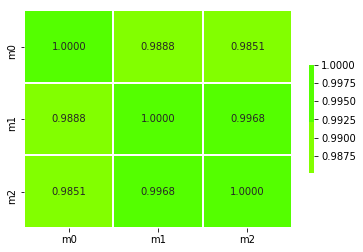

In [32]:
sns.heatmap(corr,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [56]:
rank = np.tril(concat_sub.iloc[:,1:].corr().values,0)+np.triu(np.ones(rank.shape),1)
rank

array([[1.        , 1.        , 1.        ],
       [0.98879574, 1.        , 1.        ],
       [0.98506865, 0.99680381, 1.        ]])

In [55]:
np.triu(np.ones(rank.shape),1)


array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [57]:
m = (rank>0).sum() - (rank>0.99).sum()
m

2

In [61]:
m_gmean, s = 0, 0

In [ ]:
# https://en.wikipedia.org/wiki/Weighted_geometric_mean

In [62]:
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    print('%s round wiht current minimual index%s'%(n,mx))
    weight = (m-n)/m
    print('current weight:%s'%weight)
    m_gmean += w*(np.log(concat_sub.iloc[:,mx[0]+1])+np.log(concat_sub.iloc[:,mx[1]+1]))/2
    print(m_gmean.head())
    s += w
    print(s)
    rank[mx] = 1
    print(rank)
m_gmean = np.exp(m_gmean/s)

0 round wiht current minimual index(0, 0)
current weight:1.0
0   -3.225728
1   -3.683750
2   -3.355670
3   -3.431197
4   -3.688426
Name: m0, dtype: float64
0.5
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
1 round wiht current minimual index(0, 0)
current weight:0.5
0   -6.451456
1   -7.367500
2   -6.711340
3   -6.862394
4   -7.376852
Name: m0, dtype: float64
1.0
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [38]:
m_gmean.head()

0    0.001442
1    0.000736
2    0.001189
3    0.001036
4    0.000677
Name: m0, dtype: float64

In [64]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
m_gmean.head()

0    0.001515
1    0.000567
2    0.001153
3    0.000982
4    0.000561
Name: m0, dtype: float64

In [66]:
concat_sub['isFraud'] = m_gmean
concat_sub[['TransactionID','isFraud']].to_csv('./data/sub_stack_gmean.csv',index=False)

In [68]:
concat_sub.tail()

,TransactionID,m0,m1,m2,isFraud
506686,4170235,0.005848,0.007015,0.002817,0.005790
506687,4170236,0.002687,0.004152,0.002658,0.002624
506688,4170237,0.002786,0.005243,0.003182,0.002724
506689,4170238,0.002308,0.002355,0.001059,0.002245
506690,4170239,0.003451,0.003530,0.002144,0.003390
